# Introduction
There are many machine learning models that are widely used to solve supervised learning problems—many of them are highly powerful but come at cost of being complex and difficult to understood. Then there's K-Nearest Neigbours (KNN), often regarded as one of the simplest machine learning algorithms. Despite its simplicity, KNN is quite powerful when applied in the right scenarios. As one of the core algorithms for supervised learning and its utility and power are undeniable

# What is KNN?

As a quick reminder, supervised learning is process of creating model that can predict value of target variable based on input data, using knowledge from dataset where we know the actual values of the target variables. KNN can be effectively used for both classification (target variable can take a limited number of values)  and regression (target variable can take on continuous range of values) tasks. The simplest explanation of KNN for classification tasks is that an object is classifed by plurality vote of its _k_ nearest neighbours. For regression tasks, KNN can be generalized so that an object is assigned value that is the average of the values of its _k_ nearest neigbours. However, this is just a basic overview and there are several factors to consider when using KNN to develop an effective machine learning model. \
\
A simple visualisation of K-Nearest Neighbours (KNN) can be seen in image below (@fig-knn). The yellow point represents the uknown data point that we are trying to classify. We make the prediction considering its closest **k** neighbours. For **k** = 3, the three closest points to the yellow point are two blue points and one red points. Since the majority of the neighbours are blue, would predict that the yellow point belongs to the blue class.

![K-Nearest Neighbours Visualisation @author1](assets/knn.png){width=475 fig-align=left #fig-knn}

# How does KNN work?

We are trying to solve supervised learning problem, where based on *p* features $X_{1}, ..., X_{p}$ we want to predict the value of target variable $Y$. We can put all of these features into vector $\textbf{X} = (X_{1}, ... X{_p})^T$ which we will interpret as a random vector, and one of its specific realization will be denoted as $\mathbf{x}$. Let $\mathcal{X}$ where $\textbf{x} \in \mathcal{X}$ be set containing all possible values of these features, typically, and in our case, $\mathcal{X} = \mathbb{R}^p$. Then we can can describe our training dataset as **N** pairs $(\textbf{x}_{1}, Y_{1}), ..., (\textbf{x}_{N}, Y_{N})$ where $\textbf{x}_{i}$ is vector of features and $Y_{i}$ is target variable. The basic concept of predicting value of data point $\mathbf{x} \in \mathcal{X}$ is finding the k-closest points from it (these points come from the train dataset). If we are solving regression problems, we then take the average from the target varibles of the k-closest neighbours. In classification problems (that's our case) we take the most frequent value from the target variables of the k-closest neighbours.\
\
When trying to find the best model, there are many things to consider. First of all we should define distance function.\
**Distance** also called **metric** defined on set $\mathcal{X}$ is function d: $\mathcal{X} \times \mathcal{X} \rightarrow [0, +\infty)$ such that for all $x, y, z \in \mathcal{X}$, the following conditions holds:\
\
$\text{i) } d(x,y) \geq 0$, and $d(x,y) = 0$ if and only if $x = y$ (positive definiteness)\
$\text{ii) }d(x,y) = d(y,x)$ (symmetry)\
$\text{iii) }d(x,y) \geq d(x,z) + d(z,y)$ (triangle inequality)\
The most common distance function used is KNN is Minkowski distance also called q-norm or l-metric defined as follows:\
$||x-y||_{q} = d_{q}(x,y) = \sqrt[q]{\sum_{i=1}^{p} (x_i - y_i)^q}$ Example of L1 and L2 distance @fig-metric

After we have found k-nearest neighbours, we need to somehow decide what value we should predict. In our case, we could just precict the value with the most frequent target variable. What we can also do is try weighted voting, that means that closer neighbours will have vote with higher value.\
Common choice for weight is inverse distance weighting\
$w_{i} = \frac{1}{d(x,y)}$\
For each category $c$ that target variable can be, we count the total weighted vote $W_{c} = \sum_{Y_i \in \mathcal{N}} w_i \cdot 1(Y_i = c)$\
where $\mathcal{N}$ is set of target variables of k-nearest neighbours. We then choose $\hat{y} = \arg\max_c W_c$, where $c$ is every possible category of target variable, as our prediction.


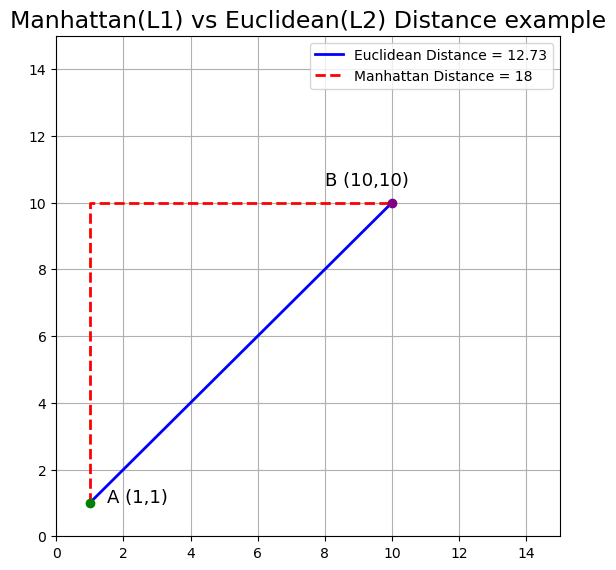

In [6]:
#| label: fig-metric
#| fig-align: left
#| fig-cap: Manhattan metric vs Euclidean metric

# Importing all libraries that will be used
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interactive
import seaborn as sns
import matplotlib.patheffects as path_effects

A = np.array([1, 1])
B = np.array([10, 10])

manhattan_distance = np.abs(A[0] - B[0]) + np.abs(A[1] - B[1])
euclidean_distance = np.linalg.norm(A - B)

plt.figure(figsize=(6.5, 6.5))
plt.plot([A[0], B[0]], [A[1], B[1]], label=f'Euclidean Distance = {euclidean_distance:.2f}', color='blue', linestyle='-', linewidth=2)
plt.plot([A[0], A[0], B[0]], [A[1], B[1], B[1]], label=f'Manhattan Distance = {manhattan_distance}', color='red', linestyle='--', linewidth=2)

plt.scatter(A[0], A[1], color='green', zorder=5)
plt.scatter(B[0], B[1], color='purple', zorder=5)

plt.text(A[0]+0.5, A[1], 'A (1,1)', fontsize=13, ha='left')
plt.text(B[0]+0.5, B[1]+0.5, 'B (10,10)', fontsize=13, ha='right')

plt.xlim(0, 15)
plt.ylim(0, 15)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True)

plt.title("Manhattan(L1) vs Euclidean(L2) Distance example", fontsize=17)
plt.legend()

plt.show()


# When to use KNN? - Advantages Vs Disadvantages
As previously mentioned, the main benefit of KNN is its simplicity, making it very easy to implement. KNN works well with data that have small amount of features and it doesn't require retraining when new data comes, you just need to adjust distances. Except for finding the best hyperparameters, KNN does not require any training, which can be beneficial in some cases. \
KNN can be computationally expensive because every time you want to predict the query point, you need to compute the distances between neihgbouring points, this means slower prediction time for larger datasets. In order to predict you need to store the whole dataset, which can be memory-intensive. The biggest drawback of KNN is the Curse of Dimensionality. As the number of features (or dimensions) increases, the data becomes increasingly sparse. This means that the distance between points grows and that the neigbouring data points won't have relevant value in prediction because they will be too far. This, however, can be partially overcome by dimension reduction \
KNN works best with medium-sized datasets that have low dimensioninality. Since KNN doesn't rely on linear assumptions, it can be used in non-linear datasets. It performs best on balanced datasets (each class has similiar number of samples).

# Dataset description

To make the explanation clearer, we'll demonstrane how KNN works by using specific dataset. Before diving into training and prediction let's briefly review the dataset that we chose. The dataset that we selected is [*Air Quality and Pollution Assesment*](https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment/data). This Dataset is derived from [World Health Organization](https://www.who.int/health-topics/air-pollution#tab=tab_1) and [World Bank Group](https://data.worldbank.org/indicator/EN.POP.DNST) 
This Dataset contains several features, in other words, columns, lets go through each one of them and explain what they mean.

- **Temperature(°C)**: Average temperature of the region
- **Humidity (%)**: Relative humidity recorded in the region
- **PM2.5 Concentration (µg/m³)**: Fine particulate matter level
- **PM10 Concentration (µg/m³)**: Coarse particulate matter levels
- **NO2 Concentration (ppb)**: Nitrogen dioxide levels
- **SO2 Concentration (ppb)**: Sulfur dioxide levels
- **CO Concentration (ppm)**: Carbon monoxide levels
- **Proximity to Industrial Areas (km)**: Distance to the nearest industrial zone
- **Population Density (people/km²)**: Number of people per square kilometer in the region

Then there is so called Target Variable, that's the variable that we are trying to predict, in our dataset, it is called **Air Quality** and it can have 4 possible values depending on Air Quality, these values are the following:

- **Good**: Clean air with low pollution levels.
- **Moderate**: Acceptable air quality but with some pollutants present.
- **Poor**: Noticeable pollution that may cause health issues for sensitive groups.
- **Hazardous**: Highly polluted air posing serious health risks to the population.n.



,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
4576,23.6,76.6,0.5,16.3,28.2,11.9,1.55,6.2,514
1088,24.6,58.0,7.5,19.0,25.7,3.4,1.57,12.7,617
479,22.3,74.3,6.5,10.9,20.7,7.6,0.92,13.0,210
727,27.2,70.5,37.6,41.9,18.9,13.9,1.68,8.2,579
3783,35.8,71.5,19.0,34.1,28.6,13.5,1.54,7.8,592


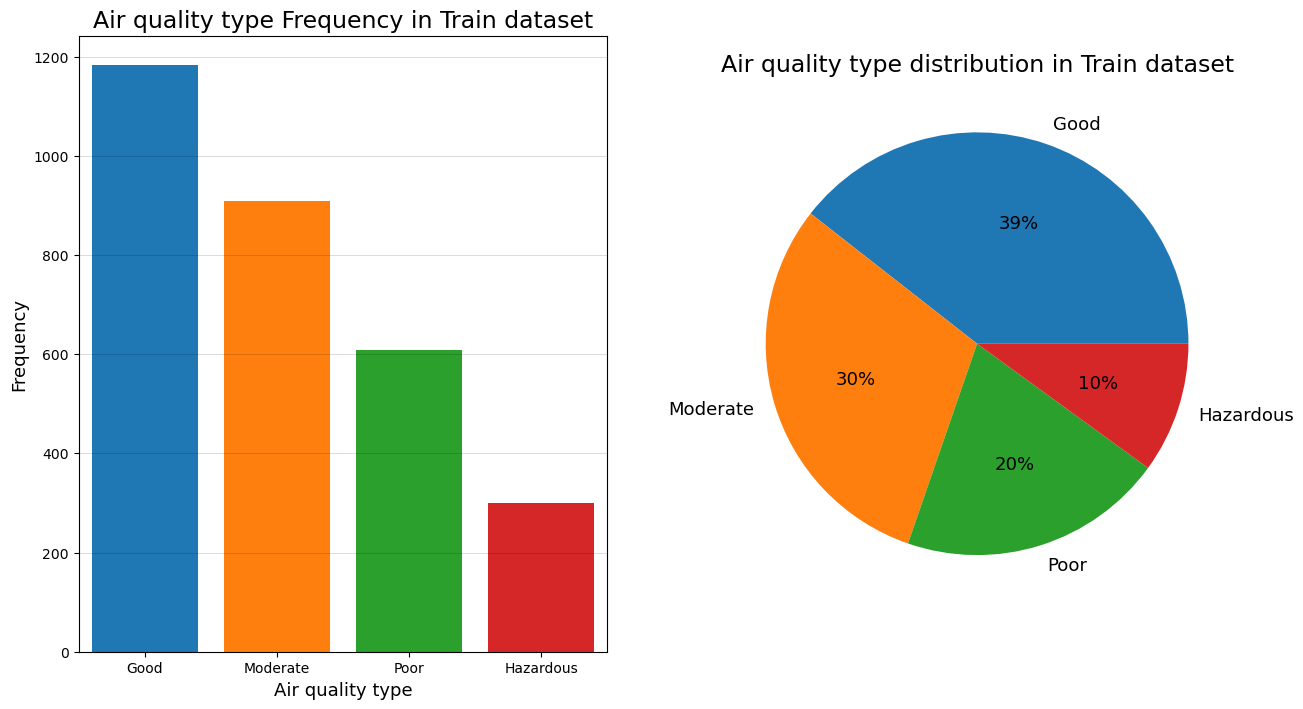

In [200]:
#| code-fold: true
#| fig-align: left
#| fig-cap:
#|  - "Dataset Overview"
#|  - "Target variable distribution in Train dataset"

# Importing all libraries that will be used
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interactive
import seaborn as sns
import matplotlib.patheffects as path_effects

def preprocess_data(df:pd.DataFrame)->pd.DataFrame:
    """ Function, for preprocessing data
    """
    qual_category = pd.api.types.CategoricalDtype(categories=['Hazardous', 'Poor', 'Moderate', 'Good'], ordered=True)
    df['Air Quality'] = df['Air Quality'].astype(qual_category)
    return df

def read_data(path:str='data/data.csv', y:str='Air Quality',**kwargs)->tuple:
    """ Function thats read data, and splits them into Train, Validation and Test datasets
    also separates, target value from others values.
    ---
    Attributes:
    path: [str], path to csv data file
    y: [str], name of Target value
    kwargs: options, use seed for random_seed
    ---
    Returns:
    tuple with Train,Validation,Test parametrs set, Target values: Train, Test, Validation
    """
    df = pd.read_csv(path)

    #display(df.info())
    #display(df.describe())
    
    df = preprocess_data(df)
    # Split the training dataset into train and rest (default 60% : 40%)
    Xtrain, Xrest, ytrain, yrest = train_test_split(
        df.drop(columns=[y]), df[y], test_size=0.4, random_state=kwargs.get('seed',42))
    # Split the rest of the data into validation dataset and test dataset (default: 24% : 16%)
    Xtest, Xval, ytest, yval = train_test_split(
        Xrest, yrest, test_size=0.5, random_state=kwargs.get('seed',42))
    #print(f'Dataset: {path} | Target value: {y} | Seed: {kwargs.get('seed',42)}')
    return Xtrain, Xtest, Xval, ytrain, ytest, yval

Xtrain, Xtest, Xval, ytrain, ytest, yval = read_data(seed=42)

df_original = Xtrain

df_tmp = ytrain.copy()
df_tmp = df_tmp.astype("category")
df_tmp_counts = df_tmp.value_counts()

custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
sns.barplot(x = df_tmp_counts.index, y = df_tmp_counts.values, ax = ax1, order=df_tmp_counts.index)
for i, bar in enumerate(ax1.patches):
    bar.set_facecolor(custom_colors[i])

ax1.set_xlabel("Air quality type", fontsize = 13);
ax1.set_ylabel("Frequency",fontsize = 13);
ax1.set_title("Air quality type Frequency in Train dataset",fontsize = 17);
ax1.grid(axis='y', color='black', alpha=.2, linewidth=.5)

animal_count = df_tmp.value_counts()
ax2 = fig.add_subplot(1,2,2)
ax2.pie(animal_count, labels=animal_count.index,autopct='%.0f%%', textprops={"fontsize": 13});
ax2.set_title("Air quality type distribution in Train dataset", fontsize = 17);

display(Xtrain.head())

# Training the model on dataset
#### Preprocessing data
After we have preprocessed the dataset we need to split the data into 3 smaller datasets. **Train**, **validate** and **test** with **train** size being 60% of the original dataset and **validate** and **test** both being 20% of the original dataset, this will play key role in the training. We will use the **train** dataset to train the model and then the **validate** dataset to find the best hyperparameters. Finally, the **test** dataset will will serve as an option to measure how good our model is.

#### Finding the Best model (Hyperparameter tuning)
When finding the best model, there are many things to consider. Our goal is to somehow maximize the classification accuracy on new data, that the model has never seen before. Accuracy is defined as\
$$\text{accuracy = }\frac{ \text{number of correctly classified}}{ \text{number of all classified}} \in (0,1)$$ The accuracy which we are trying to maximize is the accuracy of how our model built using **train** dataset will predict on **validating** dataset. In order to maximize this accuracy, we can try changing the number of neighbours (k), then we can try changing the distance metric, lastly, we can try whether using weighted distance makes any difference. We build our model using combination of these different possibilites and for every one of them we meassure the accuracy on **validating** dataset. We then choose the model with the highest accuracy.

#### The results
Using no normalization, the best accuracy we get is 0.833 with hyperparameters **k** (number of neighbours) = 8, **weights** = distance (closer points to our data point have higher value than points further away) and finally **metric** = 1 (Manhattan metric)

Best Hyperparameter values:  {'weights': 'distance', 'p': 1, 'n_neighbors': 8}


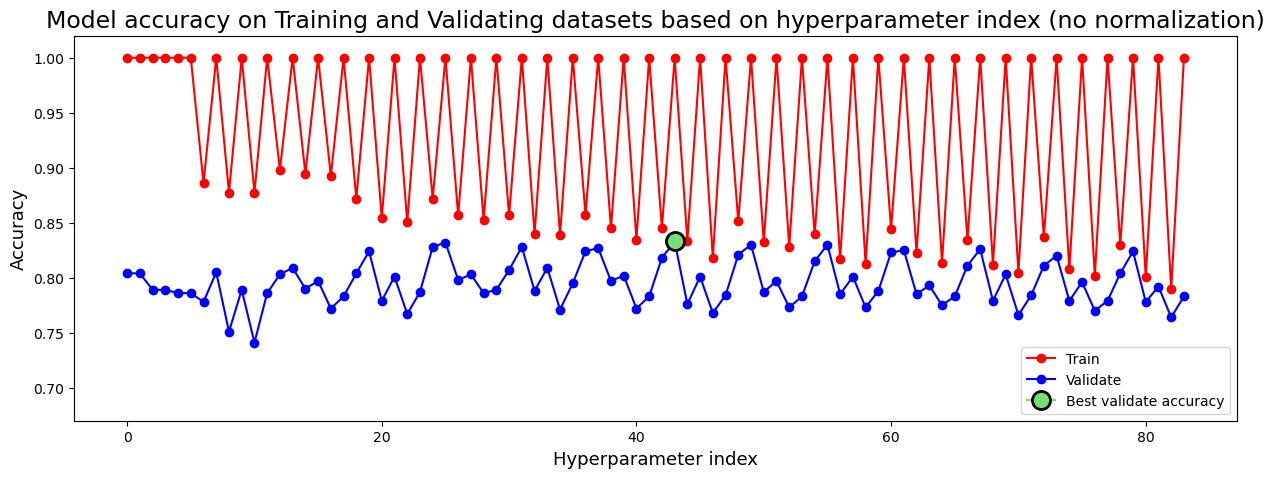

In [151]:
#| code-fold: true
#| fig-align: left
#| fig-cap: Accuracy of KNN based on hyperparameter index without normalization

def train_model(*args,**kwargs):
    """Function, that trains model with specific paraketrs, defined in kwargs.
    ---
    Attributes:
    *args: Xtrain,Ytrain
    **kwargs: options for training model
    ---
    Return: trained model
    """
    X = args[0]
    y = args[1]
    return KNeighborsClassifier(**kwargs).fit(X,y)

def find_best(*args):
    """ Function finding best parametrs for specified data
    ---
    Attributes:
    Xtrain, ytrain, Xval, Yval
    """
    param_grid = {
        'n_neighbors': range(1,15), 
        'p': range(1,4),
        'weights': ['uniform', 'distance']
    }
    param_comb = ParameterGrid(param_grid)
    val_acc = []
    train_acc = []
    for params in param_comb:
        clfKNN = KNeighborsClassifier(**params)
        clfKNN.fit(args[0], args[1])
        train_acc.append(clfKNN.score(args[0],args[1]))
        val_acc.append(clfKNN.score(args[2],args[3]))
    return param_comb[np.argmax(val_acc)], train_acc, val_acc


best_params_no_scale, train_acc, val_acc = find_best(Xtrain,ytrain,Xval,yval)

clfKNN = KNeighborsClassifier(**best_params_no_scale)
clfKNN.fit(Xtrain, ytrain)
y_knn_val = clfKNN.predict(Xval)
#display(metrics.accuracy_score(yval, y_knn_val))


fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("Model accuracy on Training and Validating datasets based on hyperparameter index (no normalization)", fontsize=17)
ax.plot(train_acc,'or-')
ax.plot(val_acc,'ob-')


max_idx = np.argmax(val_acc)
ax.plot(max_idx, val_acc[max_idx], marker='o', color='#77DD77', markersize=13, markeredgecolor='black', markeredgewidth=2)
ax.set_ylim(bottom=0.67, top=1.02)

ax.set_xlabel('Hyperparameter index', fontsize=13)
ax.set_ylabel('Accuracy', fontsize=13)
ax.legend(['Train', 'Validate', 'Best validate accuracy'], loc='lower right')

print("Best Hyperparameter values: ", best_params_no_scale)

# Normalization
One technique that can help with making the model more accurate is normalization. In some cases, the features are difficult to compare and it is essentially impossible to find a universal measure. This can be addressed by using clever methods to normalize the data using linear transformation. The simplest method used to normalize data is called **Min-Max** normalization which scales every element in selected feature into interval $[0,1]$. It is defined as follows:\
For given feature let's call its minimal value $\text{min}_x$ and the maximal value $\text{max}_x$, then we will define the value $x_i$ of this feature as\
$x_i \leftarrow \frac{ x_i - \text{min}_x}{ \text{max}_i - \text{min}_x}$

Another commonly used normalization method is standardization, defined as follows
$x_i \leftarrow \frac{x_i - \bar{x}}{\sqrt{s_x^2}}$ where $\bar{x} = \frac{1}{n} \sum_{i} x_i$ is sample mean and $s_x^2 = \frac{1}{n-1} \sum_{i}^{} {(x_i - \bar{x})^2}$ is sample variance


# Standardization Accuracy
Using Standardization, the best accuracy on **validating** dataset is 0.931, which is already much higher than the 0.833 without normalization.

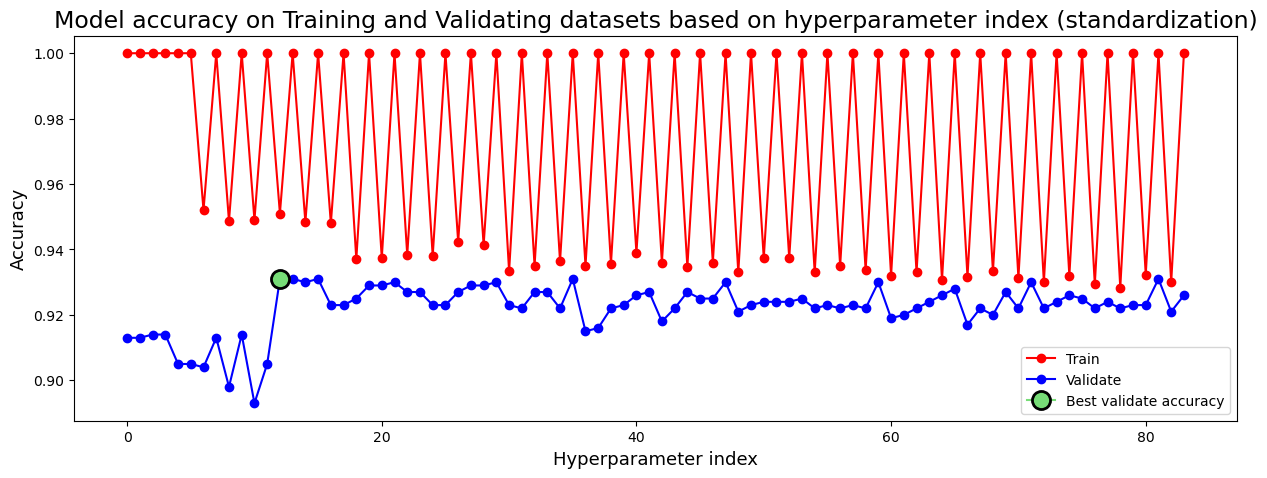

In [14]:
#| code-fold: true
#| fig-align: left
#| fig-cap: Accuracy of KNN based on hyperparameter index with Standardization

scaler = StandardScaler()
Xtrain_fit = scaler.fit_transform(Xtrain)
Xval_fit = scaler.transform(Xval)
best_params_standard, train_acc_standard, val_acc_standard = find_best(Xtrain_fit,ytrain,Xval_fit,yval)

clfKNN = KNeighborsClassifier(**best_params_standard)
clfKNN.fit(Xtrain_fit, ytrain)
y_knn_val = clfKNN.predict(Xval_fit)
#display(metrics.accuracy_score(yval, y_knn_val))

fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("Model accuracy on Training and Validating datasets based on hyperparameter index (standardization)", fontsize=17)
ax.plot(train_acc_standard,'or-')
ax.plot(val_acc_standard,'ob-')


max_idx = np.argmax(val_acc_standard)
#display(val_acc_standard[max_idx])
ax.plot(max_idx, val_acc_standard[max_idx], marker='o', color='#77DD77', markersize=13, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('Hyperparameter index', fontsize=13)
ax.set_ylabel('Accuracy', fontsize=13)
ax.legend(['Train', 'Validate', 'Best validate accuracy'])

## Min-Max Accuracy
Using Min-Max normalization, the best accuracy on **validation** dataset is 0.942, which is actually the best result we have got.

 0.942


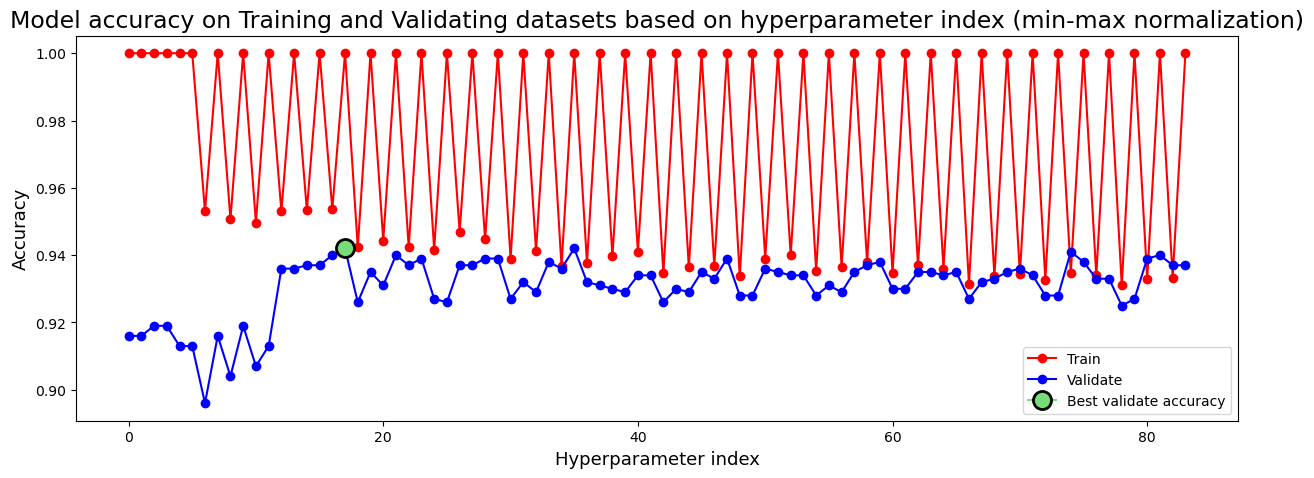

In [134]:
#| code-fold: true
#| fig-align: left
#| fig-cap: Accuracy of KNN based on hyperparameter index with MinMax Normalization

scaler = MinMaxScaler()
Xtrain_fit = scaler.fit_transform(Xtrain)
Xval_fit = scaler.transform(Xval)
best_params_minmax, train_acc_minmax, val_acc_minmax = find_best(Xtrain_fit,ytrain,Xval_fit,yval)

clfKNN = KNeighborsClassifier(**best_params_minmax)
clfKNN.fit(Xtrain_fit, ytrain)
y_knn_val = clfKNN.predict(Xval_fit)
print("", metrics.accuracy_score(yval, y_knn_val))

fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("Model accuracy on Training and Validating datasets based on hyperparameter index (min-max normalization)", fontsize=17)
ax.plot(train_acc_minmax,'or-')
ax.plot(val_acc_minmax,'ob-')


max_idx = np.argmax(val_acc_minmax)
#display(val_acc_minmax[max_idx])
ax.plot(max_idx, val_acc_minmax[max_idx], marker='o', color='#77DD77', markersize=13, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('Hyperparameter index', fontsize=13)
ax.set_ylabel('Accuracy', fontsize=13)
ax.legend(['Train', 'Validate', 'Best validate accuracy'])

# The best model
When we compare the models with and without normalization (@fig-comparison), we can see that normalization makes a huge difference. Based on the results, the best model is the model that uses Min-Max normalization, uses weighted distance, 3 neighbours and L-Norm is 3. Its accuracy on **validating** dataset is 0.942. To analyze accuracy in more detail, we can use confusion matrix (@fig-confusion), which shows where our model made correct predictions and where it failed. Finally, we would like to determine how accurate our model  will be on new data. To estimate this, we will meassure the accuracy of predictions on the **test** dataset, which provides an estimate of how well the model will perform on unseen data. The meassured accuracy is 0.921, this is the accuracy we can expect on new data.

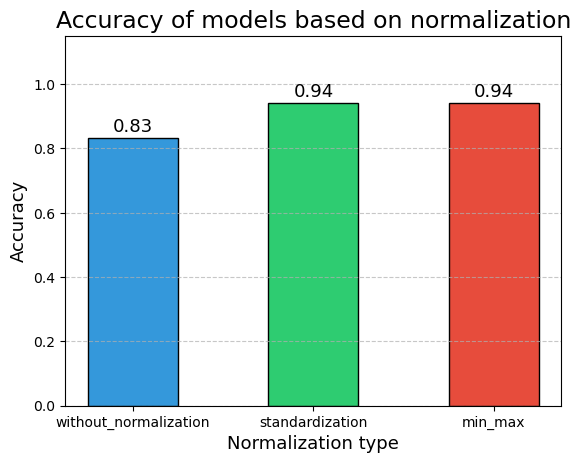

In [25]:
#| code-fold: true
#| label: fig-comparison
#| fig-align: left
#| fig-cap: Model comparison with/without normalization
max_idx = np.argmax(val_acc)
max_idx_standard = np.argmax(val_acc_standard)
max_idx_minmax = np.argmax(val_acc_minmax)

labels = ['without_normalization', 'standardization', 'min_max']
values = [val_acc[max_idx], val_acc_standard[max_idx_standard], val_acc_minmax[max_idx_minmax]] 

fig, ax = plt.subplots()

colors = ['#3498db', '#2ecc71', '#e74c3c']

ax.bar(labels, values, color=colors, edgecolor='black', width=0.5)

ax.set_ylim(0, 1.15)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax.set_xlabel("Normalization type", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
ax.set_title("Accuracy of models based on normalization", fontsize=17)

ax.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(values):
    ax.text(i, value + 0.02, f'{value:.2f}', ha='center', fontsize=13)

plt.show()


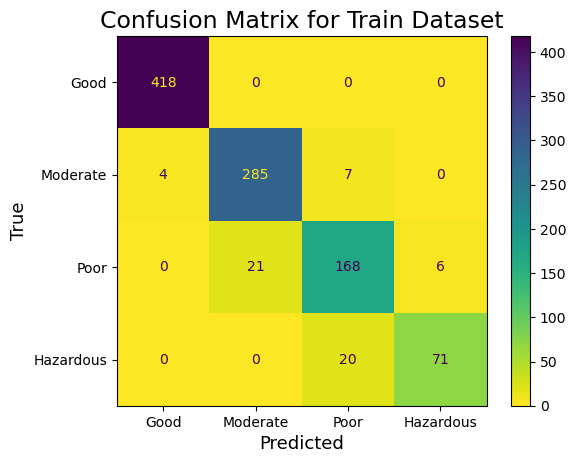

In [26]:
#| code-fold: true
#| label: fig-confusion
#| fig-align: left
#| fig-cap: Confusion Matrix (Validating dataset)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#confusionMatrixDT = metrics.confusion_matrix(yval, y_knn_val)
fig, ax = plt.subplots()
custom_order = ['Good', 'Moderate', 'Poor', 'Hazardous']

confusionMatrixDT = confusion_matrix(yval, y_knn_val, labels=custom_order)

disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrixDT,
                              display_labels=custom_order)
disp.plot(ax=ax, cmap="viridis_r")
ax.set_title("Confusion Matrix for Train Dataset", fontsize = 17)
ax.set_xlabel("Predicted", fontsize = 13);
ax.set_ylabel("True", fontsize = 13);

In [122]:
#| results: hide
#| echo: false
scaler = MinMaxScaler()
Xtrain_fit = scaler.fit_transform(Xtrain)
Xtest_fit = scaler.transform(Xtest)

clfKNN = KNeighborsClassifier(**best_params_minmax)
clfKNN.fit(Xtrain_fit, ytrain)
y_knn_val = clfKNN.predict(Xtest_fit)
print("Test dataset accuracy:", metrics.accuracy_score(ytest, y_knn_val))

Test dataset accuracy: 0.921


#### Sources:
<https://github.com/Ondralol/ML_visualization> \
<https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm> \
<https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment/data>
